<a href="https://colab.research.google.com/github/Pengyu-gis/NARR_data/blob/main/NARR_with_interactive_widget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netCDF4
!pip install cartopy

In [ ]:
!pip install ipywidgets

In [ ]:
import geopandas as gpd

# Load US county boundaries
!wget -O us-county-boundaries.zip "https://www.dropbox.com/scl/fi/up0qbz305w0t8p6u96qzk/us-county-boundaries.zip?rlkey=tih9y54tjc3d1fxfzvnu1h1zh&dl=0"
!unzip -o us-county-boundaries.zip -d ./us-county-boundaries

# Read the shapefile
counties = gpd.read_file("./us-county-boundaries/us-county-boundaries.shp")
print(counties.columns)
print(counties.head())


## Download file

In [ ]:
!wget https://downloads.psl.noaa.gov/Datasets/NARR/monolevel/wvvflx.2022.nc -O wvvflx_2022.nc

## Choose Latitude/Longitude

In [ ]:
# Specify date range and latitude/longitude bounds for the contiguous USA
date_start = pd.to_datetime('2022-01-01')
date_end = pd.to_datetime('2022-12-31')
lat_bounds = [24.396308, 49.384358]  # Latitude bounds for the contiguous USA
lon_bounds = [-125.0, -66.93457]     # Longitude bounds for the contiguous USA

# Subset the dataset based on time range
ds_subset = ds.sel(time=slice(date_start, date_end))

# Compute the conditions for latitude and longitude
lat_condition = (ds_subset.lat >= lat_bounds[0]) & (ds_subset.lat <= lat_bounds[1])
lon_condition = (ds_subset.lon >= lon_bounds[0]) & (ds_subset.lon <= lon_bounds[1])

# Use the computed conditions to index the dataset
lat_condition = lat_condition.compute()
lon_condition = lon_condition.compute()

# Apply the conditions to subset the dataset
ds_subset = ds_subset.where(lat_condition & lon_condition, drop=True)

## Compute mean

In [ ]:
# Compute the mean water vapor flux over the selected time period
mean_wvvflx = ds_subset['wvvflx'].mean(dim='time')

## Draw Plot

<ipython-input-58-d44bd77338c3>:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-58-d44bd77338c3>:43: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.clip(gdf, contiguous_usa)


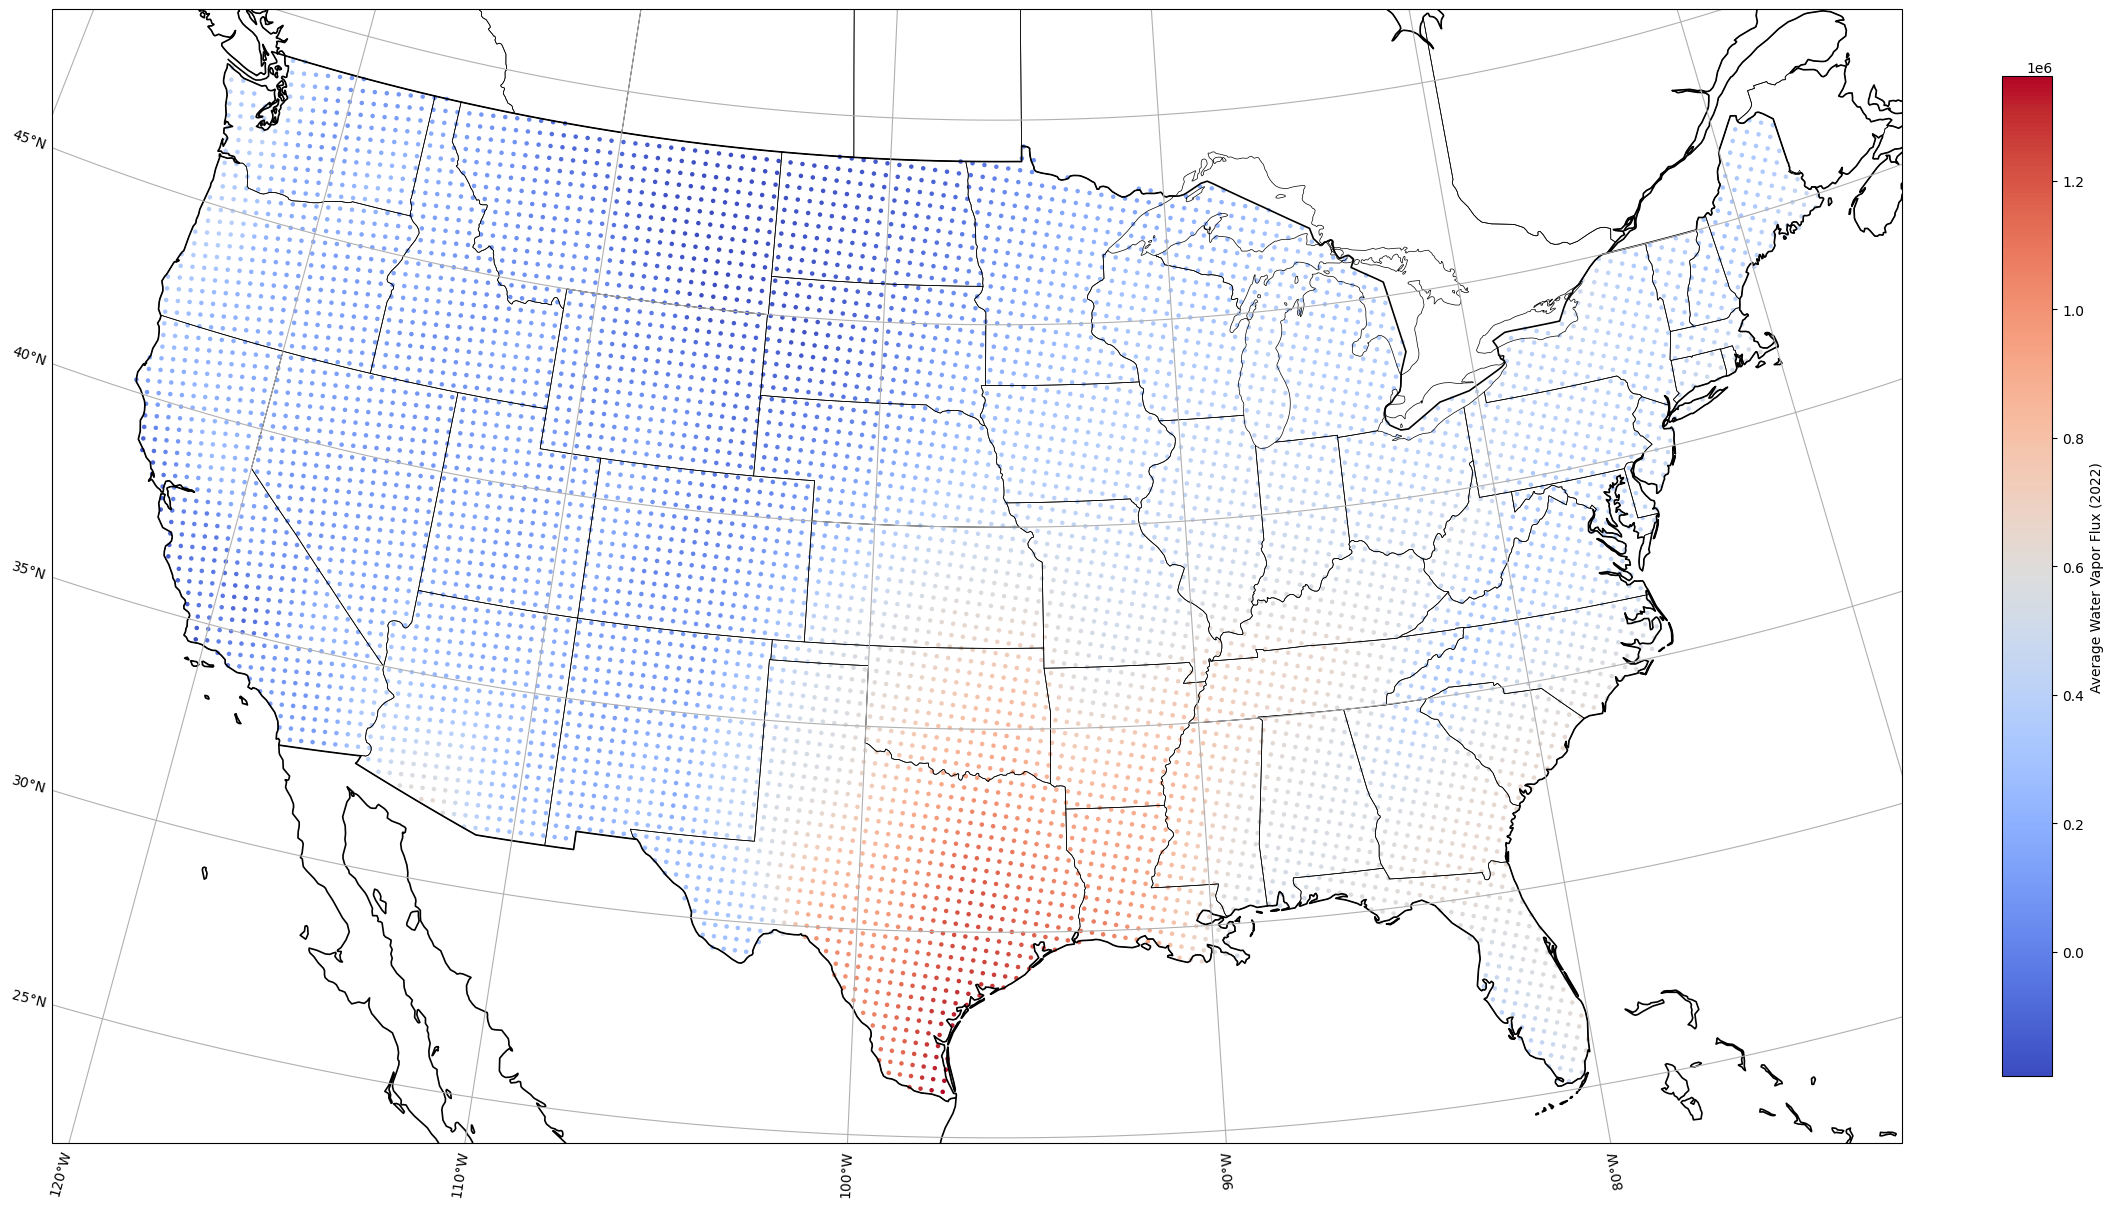

In [ ]:

# Extract latitude and longitude values
lats = ds_subset['lat'].values
lons = ds_subset['lon'].values

# Create a list of points from the latitude and longitude values
points = [Point(lon, lat) for lat, lon in zip(lats.flatten(), lons.flatten())]

# Create a DataFrame and then GeoDataFrame
df = pd.DataFrame({'geometry': points, 'wvvflx': mean_wvvflx.values.flatten()})
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Drop rows with NaN values (if any)
gdf = gdf.dropna(subset=['wvvflx'])

# Load the US states shapefile and filter for the contiguous USA
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
contiguous_usa = usa[(usa['name'] == 'United States of America') & (usa['geometry'].apply(lambda x: x.is_valid))]

# Clip the data to the contiguous USA
gdf = gpd.clip(gdf, contiguous_usa)

# Define the plot with Lambert Conformal Conic projection
fig, ax = plt.subplots(1, 1, figsize=(20, 12), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5)})

# Add features
ax.add_feature(cfeature.BORDERS, linewidth=1.2)
ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot the GeoDataFrame
cmap = plt.get_cmap('coolwarm')
gdf.plot(column='wvvflx', cmap=cmap, ax=ax, markersize=5, transform=ccrs.PlateCarree())

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=gdf['wvvflx'].min(), vmax=gdf['wvvflx'].max()))
sm._A = []  # fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.05)
cbar.set_label('Average Water Vapor Flux (2022)')

# Add state names, but exclude the name "United States of America"
for idx, row in contiguous_usa.iterrows():
    if row['name'] != 'United States of America':
        if isinstance(row.geometry, Polygon):
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, row['name'], fontsize=10, ha='center', transform=ccrs.PlateCarree())
        elif isinstance(row.geometry, MultiPolygon):
            # Iterate over each Polygon in the MultiPolygon to find the largest one
            largest_polygon = max(row.geometry.geoms, key=lambda a: a.area)
            centroid = largest_polygon.centroid
            ax.text(centroid.x, centroid.y, row['name'], fontsize=10, ha='center', transform=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Remove the frame and white margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()


/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:431: SerializationWarning: variable 'wvvflx' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
<ipython-input-13-fbdb1232420b>:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-13-fbdb1232420b>:37: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.clip(gdf, contiguous_usa)


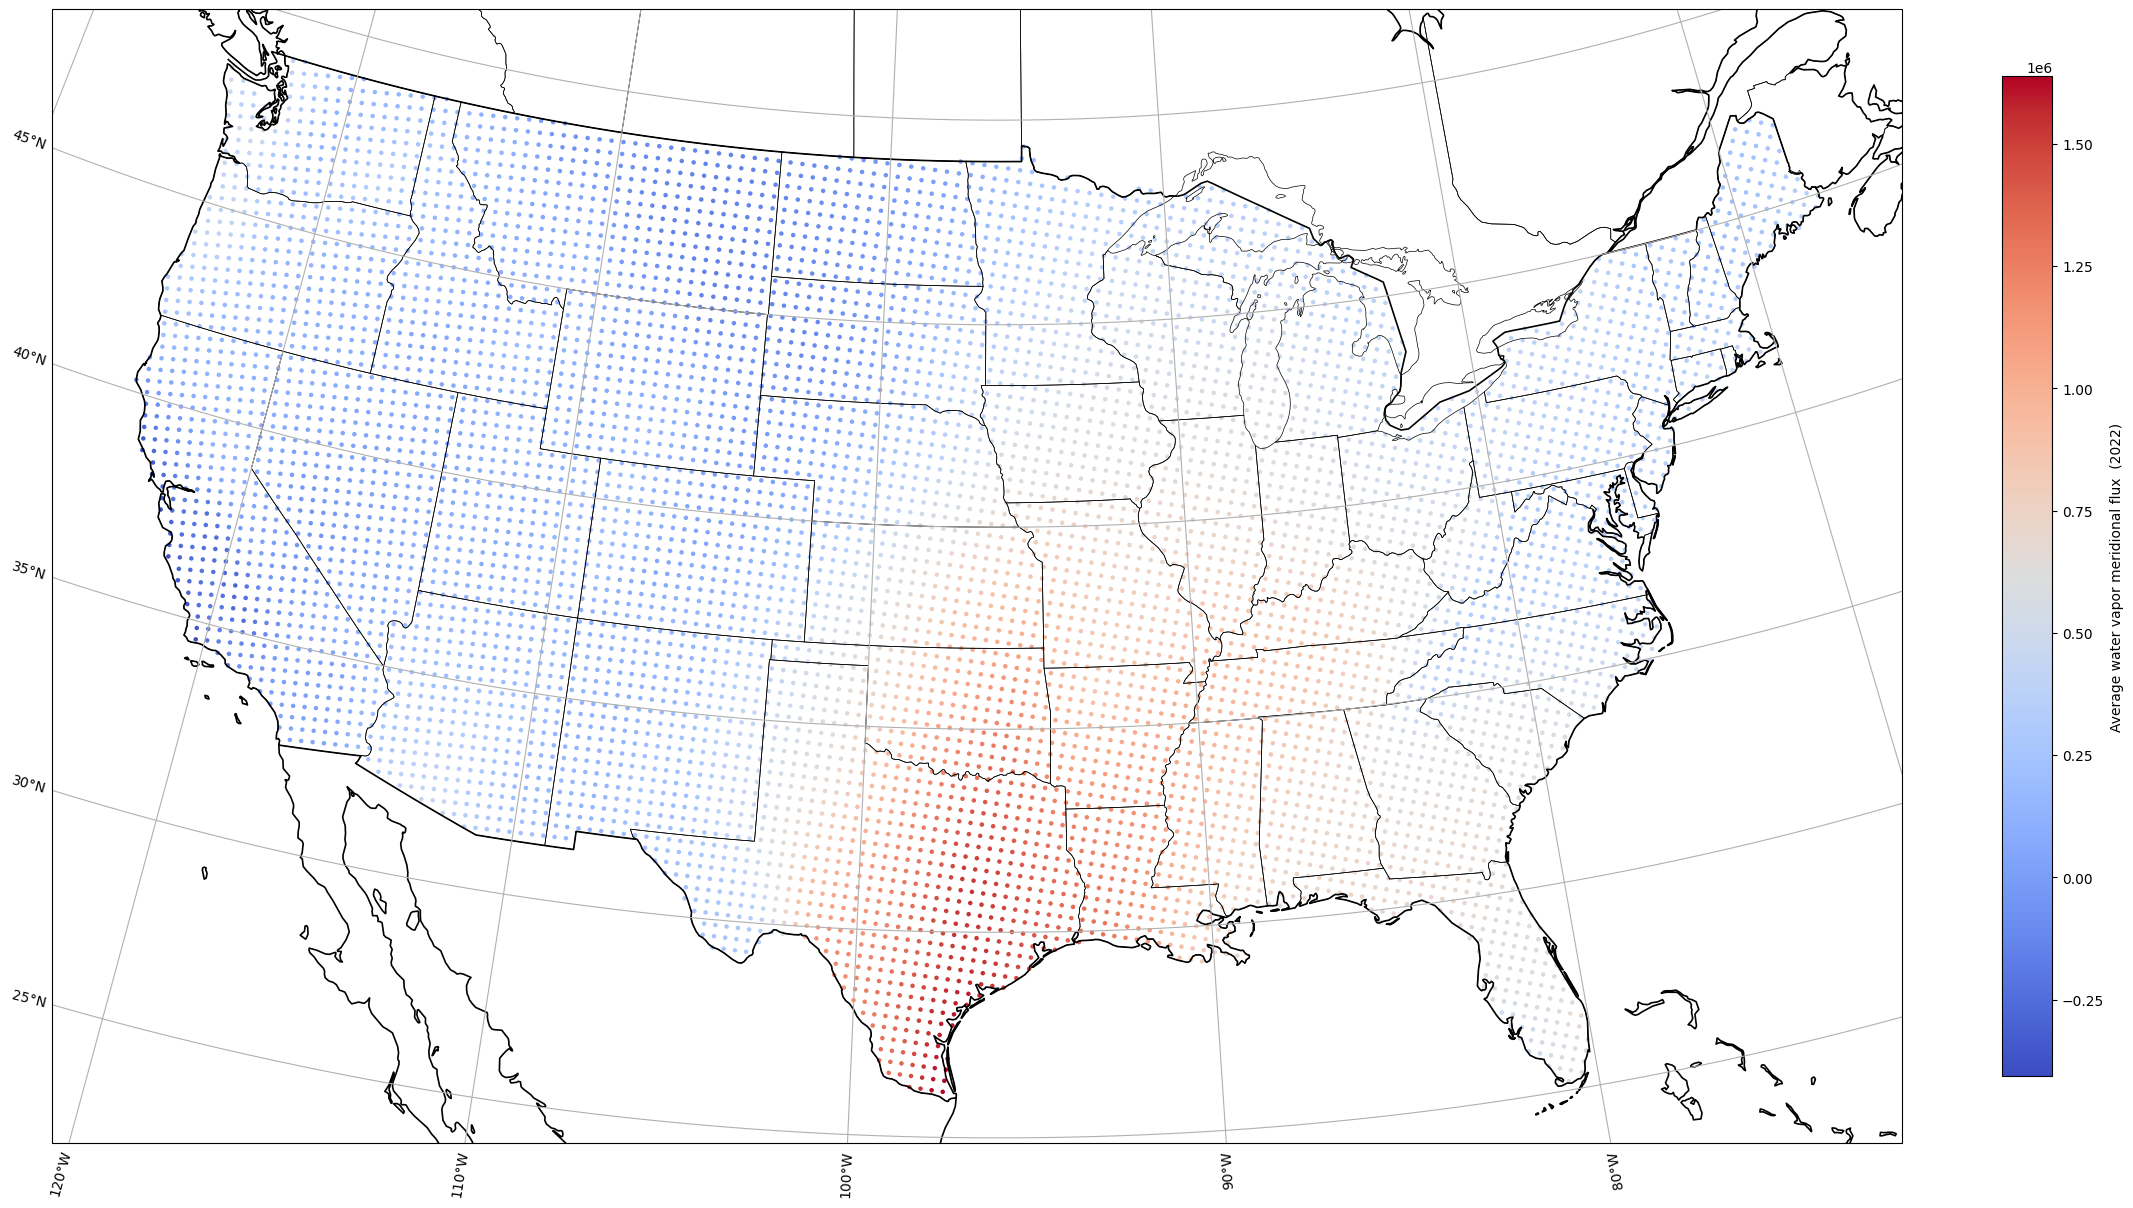

In [13]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display

# Define the function to load and subset data
def load_and_subset_data(local_file, date_start, date_end, lat_bounds, lon_bounds):
    ds = xr.open_dataset(local_file)
    ds_subset = ds.sel(time=slice(date_start, date_end))
    lat_condition = (ds_subset.lat >= lat_bounds[0]) & (ds_subset.lat <= lat_bounds[1])
    lon_condition = (ds_subset.lon >= lon_bounds[0]) & (ds_subset.lon <= lon_bounds[1])
    ds_subset = ds_subset.where(lat_condition & lon_condition, drop=True)
    return ds_subset

# Define the function to calculate mean value
def calculate_mean_value(ds_subset, variable):
    mean_value = ds_subset[variable].mean(dim='time')
    return mean_value

# Define the function to convert to GeoDataFrame
def convert_to_geodataframe(mean_value, lats, lons):
    points = [Point(lon, lat) for lat, lon in zip(lats.flatten(), lons.flatten())]
    df = pd.DataFrame({'geometry': points, 'value': mean_value.values.flatten()})
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.dropna(subset=['value'])
    return gdf

# Define the function to clip to contiguous USA
def clip_to_contiguous_usa(gdf):
    usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    contiguous_usa = usa[(usa['name'] == 'United States of America') & (usa['geometry'].apply(lambda x: x.is_valid))]
    gdf = gpd.clip(gdf, contiguous_usa)
    return gdf, contiguous_usa

# Define the function to plot data
def plot_data(gdf, contiguous_usa, variable_name):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5)})
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    cmap = plt.get_cmap('coolwarm')
    gdf.plot(column='value', cmap=cmap, ax=ax, markersize=5, transform=ccrs.PlateCarree())

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=gdf['value'].min(), vmax=gdf['value'].max()))
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.05)
    cbar.set_label(f'Average {variable_name} (2022)')

    for idx, row in contiguous_usa.iterrows():
        if row['name'] != 'United States of America':
            if isinstance(row.geometry, Polygon):
                centroid = row.geometry.centroid
                ax.text(centroid.x, centroid.y, row['name'], fontsize=10, ha='center', transform=ccrs.PlateCarree())
            elif isinstance(row.geometry, MultiPolygon):
                largest_polygon = max(row.geometry.geoms, key=lambda a: a.area)
                centroid = largest_polygon.centroid
                ax.text(centroid.x, centroid.y, row['name'], fontsize=10, ha='center', transform=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

# Define interactive widgets
narr_url = widgets.Text(
    value='Expected file',
    description='Local File:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

date_start = widgets.DatePicker(
    description='Start Date:',
    disabled=False
)

date_end = widgets.DatePicker(
    description='End Date:',
    disabled=False
)

lat_bounds = widgets.FloatRangeSlider(
    value=[24.396308, 49.384358],
    min=-90,
    max=90,
    step=0.1,
    description='Latitude Bounds:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='75%')
)

lon_bounds = widgets.FloatRangeSlider(
    value=[-125.0, -66.93457],
    min=-180,
    max=180,
    step=0.1,
    description='Longitude Bounds:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='75%')
)

variable = widgets.Text(
    value='Expected Variable',
    description='Variable:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

variable_name = widgets.Text(
    value='Expected Variable name',
    description='Variable Name:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Define the function to run the analysis and plot
def run_analysis(narr_url, date_start, date_end, lat_bounds, lon_bounds, variable, variable_name):
    # Convert date pickers to string format
    date_start = date_start.strftime('%Y-%m-%d')
    date_end = date_end.strftime('%Y-%m-%d')

    # Load and subset data
    ds_subset = load_and_subset_data(narr_url, date_start, date_end, lat_bounds, lon_bounds)

    # Calculate mean value
    mean_value = calculate_mean_value(ds_subset, variable)

    # Convert to GeoDataFrame
    lats = ds_subset['lat'].values
    lons = ds_subset['lon'].values
    gdf = convert_to_geodataframe(mean_value, lats, lons)

    # Clip to contiguous USA
    gdf, contiguous_usa = clip_to_contiguous_usa(gdf)

    # Plot data
    plot_data(gdf, contiguous_usa, variable_name)

# Create interactive form
form = widgets.VBox([
    narr_url,
    date_start,
    date_end,
    lat_bounds,
    lon_bounds,
    variable,
    variable_name,
    widgets.Button(description='Run Analysis', button_style='info', icon='check')
])

def on_button_clicked(b):
    run_analysis(narr_url.value, date_start.value, date_end.value, lat_bounds.value, lon_bounds.value, variable.value, variable_name.value)

form.children[-1].on_click(on_button_clicked)

display(form)
